In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os 

In [2]:
NUM_CLASSES = 10
NUM_CLASSES_REDUCED = 2
n_epochs = 1 # 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
train_mnist = torchvision.datasets.MNIST('mnist', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))


test_mnist = torchvision.datasets.MNIST('mnist', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))]))

In [4]:
import reduceClasses

reduced_train_mnist = reduceClasses.reduce(train_mnist, NUM_CLASSES_REDUCED)
reduced_test_mnist = reduceClasses.reduce(test_mnist, NUM_CLASSES_REDUCED)

/Users/caralee/opt/miniconda3/lib/python3.9/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/Users/caralee/opt/miniconda3/lib/python3.9/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [5]:
import binaryRatio

reduced_train_mnist_ratio = binaryRatio.ratio(train_mnist, 2, (100, 1))

In [6]:
train_loader_reduced = DataLoader(reduced_train_mnist, batch_size=batch_size_train, shuffle=False) 
train_loader_reduced_ratio = DataLoader(reduced_train_mnist_ratio, batch_size=batch_size_train, shuffle=False)
train_loader_normal = DataLoader(train_mnist, batch_size=batch_size_train, shuffle=False)

test_loader_reduced = DataLoader(reduced_test_mnist, batch_size=batch_size_test, shuffle=False) 
test_loader_normal = DataLoader(test_mnist, batch_size=batch_size_test, shuffle=False)

In [7]:
train_loader = train_loader_reduced_ratio
test_loader = test_loader_reduced

In [8]:
examples = enumerate(test_loader) # enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

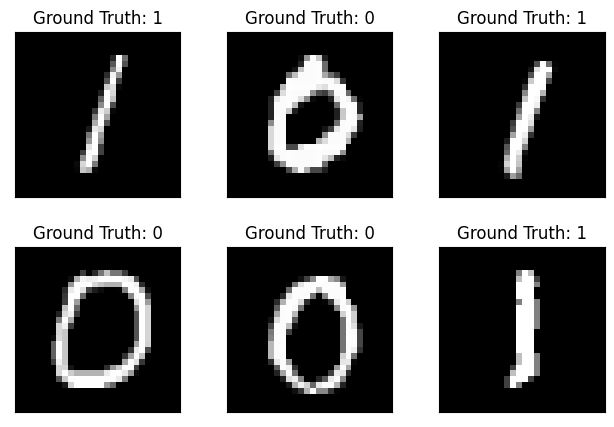

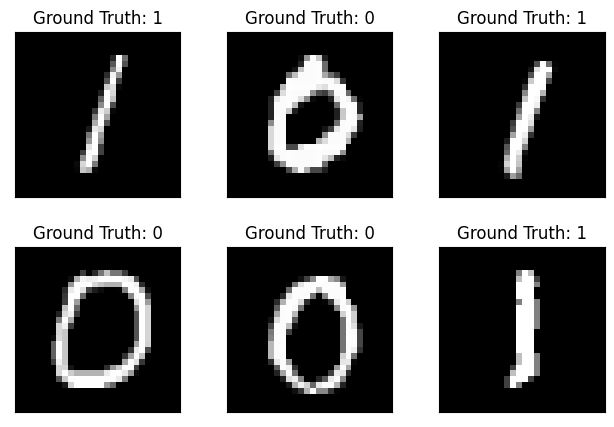

In [9]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [10]:
import Net

In [11]:
network = Net.Net(NUM_CLASSES_REDUCED) # need to tune hyperperameters / layers
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [12]:
import train 
import test 

In [13]:
for epoch in range(n_epochs):
    train_counter, train_losses = train.train(epoch, train_loader, network, optimizer)
    
    test_counter = [i*len(train_loader.dataset) for i in range(n_epochs)]
    test_losses, _, _ = test.test(test_loader, network)

/Users/caralee/Downloads/ML/numbers mnist/Net.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 0 [0/5982 (0%)]	Loss: 4.973931

Test set: Avg. loss: 0.0008, Accuracy: 1337/2115 (63%)



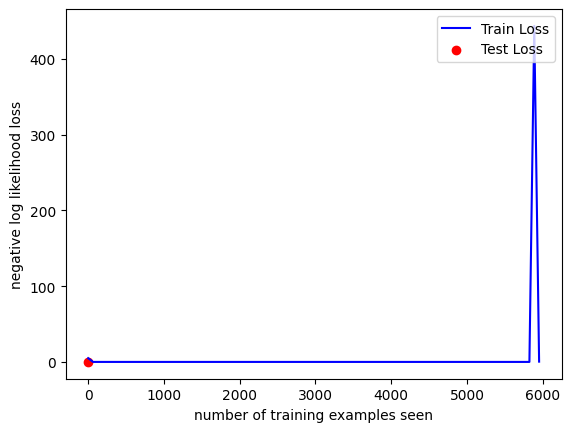

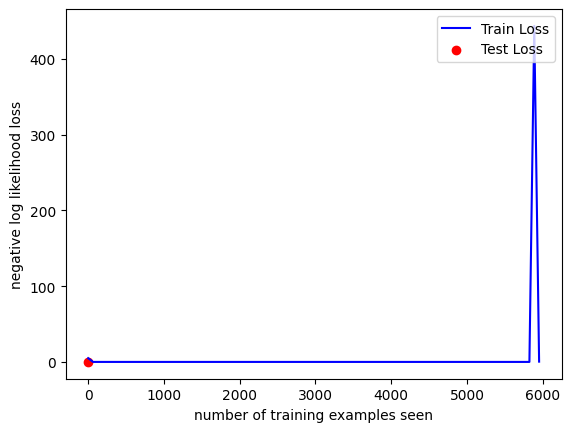

In [14]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [15]:
with torch.no_grad():
  output = network(example_data)

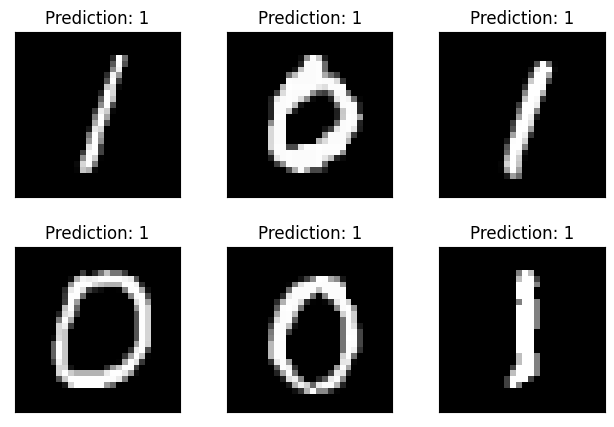

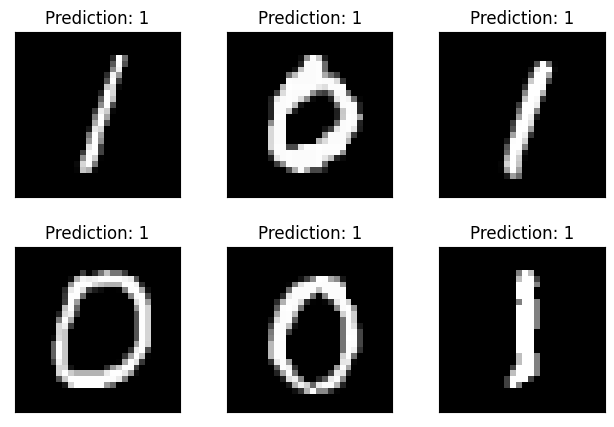

In [16]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

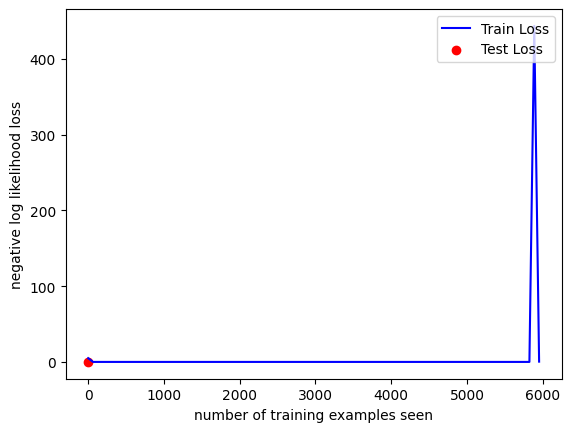

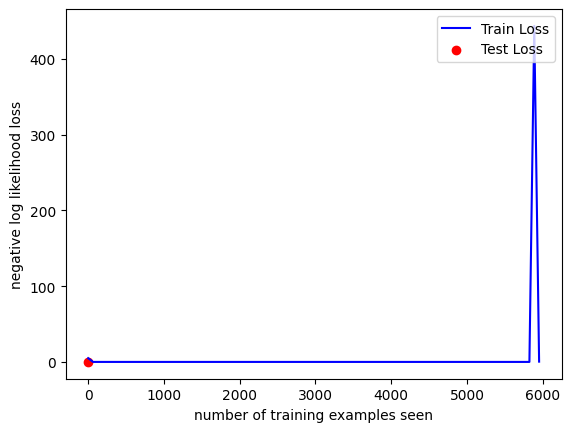

In [17]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [18]:
def return_test(test_loader, network):
    network.eval()
    preds = []
    true = []
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            pred = output.data.max(1, keepdim=True)[1]
            preds.extend(pred)
            true.extend(target)

        return preds, true

In [19]:
def get_confidence_interval(y_pred, y_true, verbose=True):
    y_pred = np.asarray(y_pred)
    y_true = np.asarray(y_true)
    n_bootstraps = 1000
    rng_seed = 42  # control reproducibility
    bootstrapped_scores = []

    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_pred) - 1, len(y_pred))
        
        score = sum(y_pred[indices]==y_true[indices])/len(y_pred)
        bootstrapped_scores.append(score)


    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    
    accuracy = sum(y_pred==y_true)/len(y_pred)
    

    # Computing the lower and upper bound of the 90% confidence interval
    # You can change the bounds percentiles to 0.025 and 0.975 to get
    # a 95% confidence interval instead.
    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    if verbose:
        print("Accuracy: {} [{:0.3f} - {:0.3}]".format(
          accuracy, confidence_lower, confidence_upper))
    return confidence_lower, confidence_upper, accuracy

In [20]:
"""
os.remove("results/model_0.pt")
os.remove("results/model_1.pt")
os.remove("results/model_2.pt")
os.remove("results/model_3.pt")
os.remove("results/model_4.pt")
"""

network = Net.Net(10) 
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)


for i in range(5):
    train.train(i, train_loader_reduced_ratio, network, optimizer)
    
    _, y_pred, y_true = test.test(test_loader_reduced, network)
 #   get_confidence_interval(y_pred, y_true)

Train Epoch: 0 [0/5982 (0%)]	Loss: 12.649661

Test set: Avg. loss: 0.0471, Accuracy: 1135/2115 (54%)

Train Epoch: 1 [0/5982 (0%)]	Loss: 105.441223

Test set: Avg. loss: 0.0028, Accuracy: 1254/2115 (59%)

Train Epoch: 2 [0/5982 (0%)]	Loss: 60.646206

Test set: Avg. loss: 0.0031, Accuracy: 980/2115 (46%)

Train Epoch: 3 [0/5982 (0%)]	Loss: 11611.579102

Test set: Avg. loss: 170669.7608, Accuracy: 938/2115 (44%)

Train Epoch: 4 [0/5982 (0%)]	Loss: 26698512.000000

Test set: Avg. loss: 0.0028, Accuracy: 980/2115 (46%)




Test set: Avg. loss: 344598249.4720, Accuracy: 980/10000 (10%)

1000


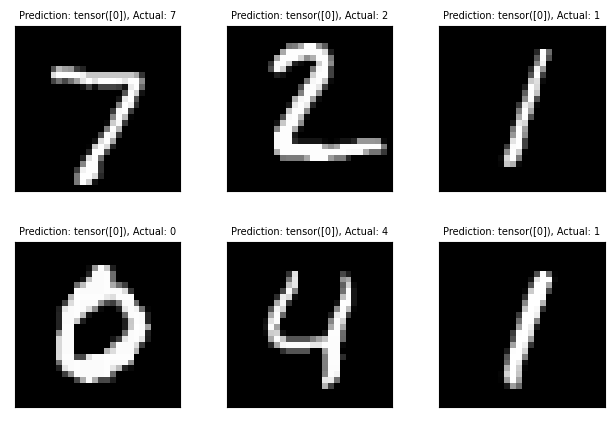

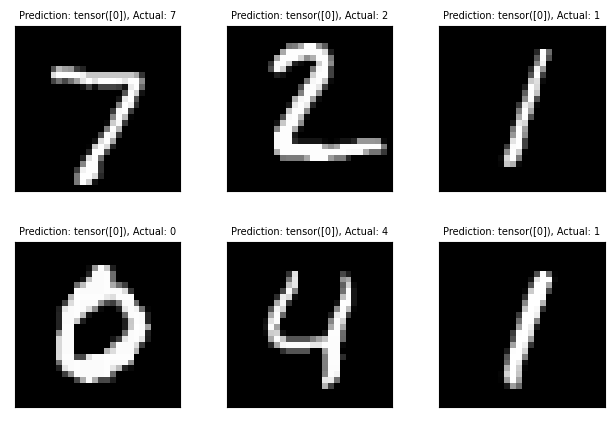

In [21]:
examples = enumerate(test_loader_normal) 
batch_idx, (example_data, example_targets) = next(examples)


    

_, y_pred, y_true = test.test(test_loader_normal, network) 

print(len(example_data))

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
 # plt.title("Ground Truth: {}".format(y_pred[i]))
  plt.title("Prediction: {}, Actual: {}".format(
    y_pred[i], y_true[i]), fontsize=7)
  plt.xticks([])
  plt.yticks([])
fig

In [22]:
continued_network = Net.Net(NUM_CLASSES_REDUCED)

network_state_dict = torch.load("results/model_0.pt")
continued_network.load_state_dict(network_state_dict)

get_confidence_interval(*return_test(test_loader, continued_network))


network_state_dict = torch.load("results/model_1.pt")
continued_network.load_state_dict(network_state_dict)

get_confidence_interval(*return_test(test_loader, continued_network))


network_state_dict = torch.load("results/model_2.pt")
continued_network.load_state_dict(network_state_dict)

get_confidence_interval(*return_test(test_loader, continued_network))


network_state_dict = torch.load("results/model_3.pt")
continued_network.load_state_dict(network_state_dict)

get_confidence_interval(*return_test(test_loader, continued_network))


network_state_dict = torch.load("results/model_4.pt")
continued_network.load_state_dict(network_state_dict)

get_confidence_interval(*return_test(test_loader, continued_network))



RuntimeError: Error(s) in loading state_dict for Net:
	size mismatch for fc2.weight: copying a param with shape torch.Size([10, 50]) from checkpoint, the shape in current model is torch.Size([2, 50]).
	size mismatch for fc2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([2]).

In [23]:
import copy

accuracies = []

original_network = Net.Net(NUM_CLASSES_REDUCED)
original_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                  momentum=momentum)

for i in range(3): 
    network = copy.deepcopy(original_network)
    optimizer = copy.deepcopy(original_optimizer)
    #curr_model_accuracies = []
    for j in range(5): 
        _, _ = train.train(j, train_loader_reduced, network, optimizer)
        
        _, y_pred, y_true = test.test(test_loader_reduced, network)
  #  curr_model_accuracies.append(get_confidence_interval(y_pred, y_true, verbose=False))
    
    #accuracies.append(curr_model_accuracies)
    
    accuracies.append(get_confidence_interval(y_pred, y_true, verbose=False))
        

Train Epoch: 0 [0/12665 (0%)]	Loss: 8.649813

Test set: Avg. loss: 0.0051, Accuracy: 293/2115 (14%)

Train Epoch: 1 [0/12665 (0%)]	Loss: 5.236827

Test set: Avg. loss: 0.0051, Accuracy: 293/2115 (14%)

Train Epoch: 2 [0/12665 (0%)]	Loss: 6.125019

Test set: Avg. loss: 0.0051, Accuracy: 293/2115 (14%)

Train Epoch: 3 [0/12665 (0%)]	Loss: 7.218546

Test set: Avg. loss: 0.0051, Accuracy: 293/2115 (14%)

Train Epoch: 4 [0/12665 (0%)]	Loss: 6.825987

Test set: Avg. loss: 0.0051, Accuracy: 293/2115 (14%)



/var/folders/d6/bv4g7hvj1djb5t2sztlk98y00000gn/T/ipykernel_19732/2681702239.py:2: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  y_pred = np.asarray(y_pred)
/var/folders/d6/bv4g7hvj1djb5t2sztlk98y00000gn/T/ipykernel_19732/2681702239.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_pred = np.asarray(y_pred)


Train Epoch: 0 [0/12665 (0%)]	Loss: 8.791140

Test set: Avg. loss: 0.0051, Accuracy: 293/2115 (14%)

Train Epoch: 1 [0/12665 (0%)]	Loss: 9.350229

Test set: Avg. loss: 0.0051, Accuracy: 293/2115 (14%)

Train Epoch: 2 [0/12665 (0%)]	Loss: 9.054405

Test set: Avg. loss: 0.0051, Accuracy: 293/2115 (14%)

Train Epoch: 3 [0/12665 (0%)]	Loss: 7.358603

Test set: Avg. loss: 0.0051, Accuracy: 293/2115 (14%)

Train Epoch: 4 [0/12665 (0%)]	Loss: 8.564595

Test set: Avg. loss: 0.0051, Accuracy: 293/2115 (14%)

Train Epoch: 0 [0/12665 (0%)]	Loss: 5.559260

Test set: Avg. loss: 0.0051, Accuracy: 293/2115 (14%)

Train Epoch: 1 [0/12665 (0%)]	Loss: 6.218196

Test set: Avg. loss: 0.0051, Accuracy: 293/2115 (14%)

Train Epoch: 2 [0/12665 (0%)]	Loss: 8.701285

Test set: Avg. loss: 0.0051, Accuracy: 293/2115 (14%)

Train Epoch: 3 [0/12665 (0%)]	Loss: 7.998539

Test set: Avg. loss: 0.0051, Accuracy: 293/2115 (14%)

Train Epoch: 4 [0/12665 (0%)]	Loss: 7.348080

Test set: Avg. loss: 0.0051, Accuracy: 293/21

In [ ]:
for model_accuracies in accuracies:
    for epoch, epoch_acc in enumerate(model_accuracies):
        print("Epoch: " + str(epoch) + ", Confidence interval: " + str(epoch_acc[0]) + "-" + str(epoch_acc[1]) + ", Accuracy: " + str(epoch_acc[2]) +
              "\n")
    print("\n")
                                                                                    